In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import numpy.linalg as la

import warnings
import freud
import freud.locality
from typing import Optional
import scipy.ndimage

from numba import njit

In [24]:
%config InlineBackend.figure_format = 'retina'

In [2]:
traj = gsd.hoomd.open("../test_fire.gsd")

In [3]:
snap = traj[0]

In [4]:
@njit
def cube_pbc_wrap(init_x, final_x, box):
    out = np.zeros(3)
    for i in range(3):
        b = box[i]
        v = init_x[i]
        w = final_x[i]
        b2 = .5*b
        dx = w - v
        if dx > b2:
            dx -= b
        elif dx < -b2:
            dx += b
        out[i] = dx
    return out

box = snap.configuration.box

cube_pbc_wrap(np.array([0.0, 0.0, 0.0]), np.array([3.0, 2.5, 4.0]), box)

array([-2.97520638,  2.5       , -1.97520638])

In [6]:


def p_hop_interal(
        pos: np.ndarray,
        tr_frames: int
) -> np.ndarray:
    """Fast implementation of phop using numba.

    Scans through the array of postions and calculates phop with the given t_r.

    Arguments
    ---------
    * pos: 3D ndarray of particle coordinates.
    * tr_frames: Size of the scanning window, t_r. Actual calculation will use
        one additional frame at the beginning of the interval.

    Returns
    -------
    * p_hop: 2D ndarray quantifying dynamical activity.
    """

    n_frames = len(pos)
    half = int(tr_frames/2)

    phop = np.zeros((n_frames - tr_frames, len(pos[0])))

    for i in range(len(phop)):
        r_A = pos[i:i+half+1]
        r_B = pos[i+half:i+tr_frames+1]

        # phop[i] = p_hop_calc(r_A, r_B)

        phop[i] = np.sqrt(
            np.mean(np.sum(np.square(r_A - np.mean(r_B, axis=0)), axis=-1), axis=0) *
            np.mean(np.sum(np.square(r_B - np.mean(r_A, axis=0)), axis=-1), axis=0)
        )

    return phop

def get_freud_box(snapshot: gsd.hoomd.Snapshot) -> freud.box.Box:

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        box: freud.box.Box = freud.box.Box(
            *snapshot.configuration.box,
            snapshot.configuration.dimensions == 2)
        return box

def calc_phop(
        traj: gsd.hoomd.HOOMDTrajectory,
        tr_frames: int = 10,
        time_ave_frames: Optional[int] = None
) -> np.ndarray:

    assert(tr_frames % 2 == 0)
    assert(tr_frames > 0)
    assert(len(traj) > tr_frames)

    n_frames = len(traj)
    init_pos = traj[0].particles.position
    pos = np.zeros((n_frames, *init_pos.shape))
    pos[0] = init_pos
    unwrap = np.zeros(init_pos.shape, dtype=np.int64)
    box = get_freud_box(traj[0])
    L = box.Lx
    L2 = L/2.0

    # wrap box positions, should probably refactor this
    # this assumes that the box does not change during the simulation
    for i in range(1, n_frames):
        pos[i] = traj[i].particles.position
        diff = pos[i] - init_pos
        unwrap += np.trunc(diff/L2).astype(np.int64)
        init_pos = pos[i].copy()
        pos[i] -= unwrap.astype(np.float64)*L

    if time_ave_frames is not None:
        pos = scipy.ndimage.uniform_filter1d(pos, time_ave_frames, axis=0)

    phop = p_hop_interal(pos, tr_frames)  # calc p_hop

    return phop

In [19]:
phop = calc_phop(traj, tr_frames=100)

In [69]:
test_id = 200

Text(0, 0.5, '$N$')

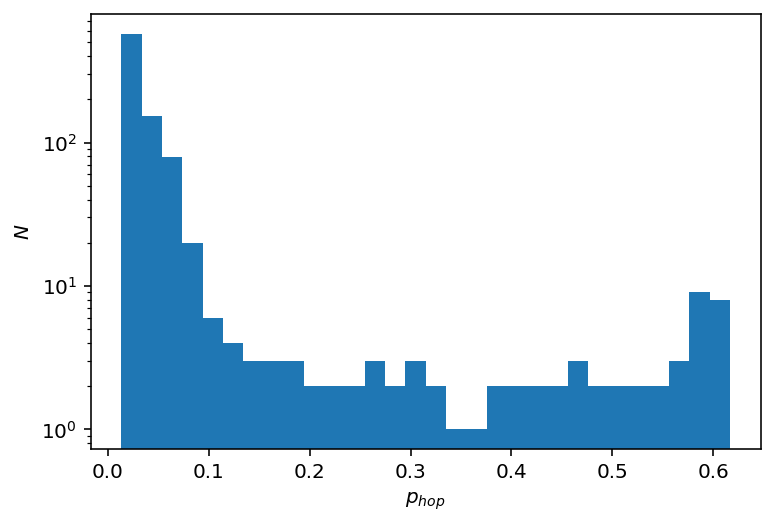

In [70]:
plt.hist(phop[:,test_id], bins=30)
plt.yscale('log')
plt.xlabel(r'$p_{hop}$')
plt.ylabel(r"$N$")

Text(0.5, 0, '$t$')

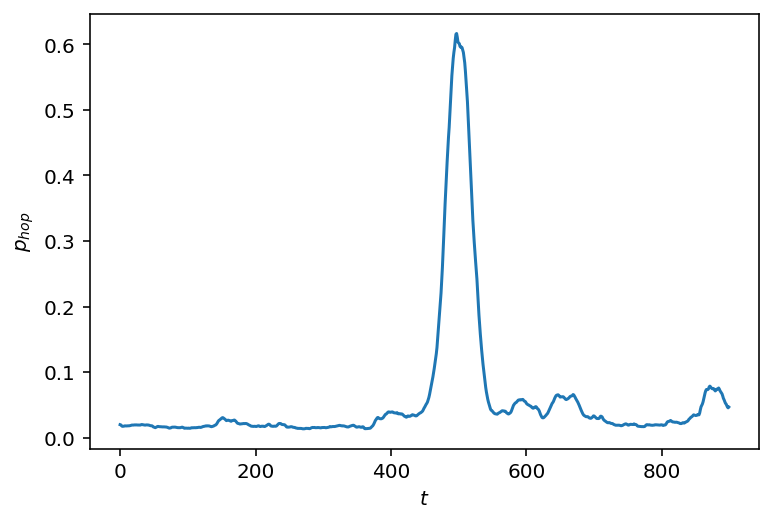

In [71]:
plt.plot(phop[:,test_id])
plt.ylabel(r'$p_{hop}$')
plt.xlabel(r"$t$")

Text(0.5, 0, '$t$')

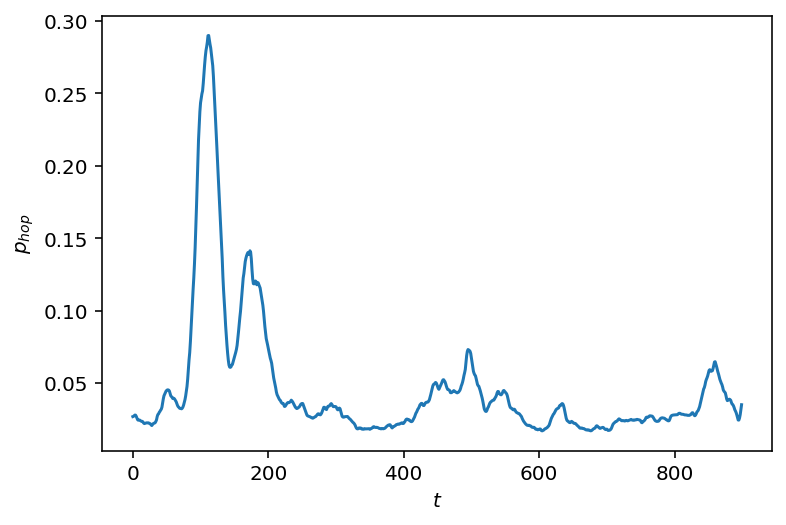

In [67]:
plt.plot(phop[:,test_id])
plt.ylabel(r'$p_{hop}$')
plt.xlabel(r"$t$")

Text(0, 0.5, '$N$')

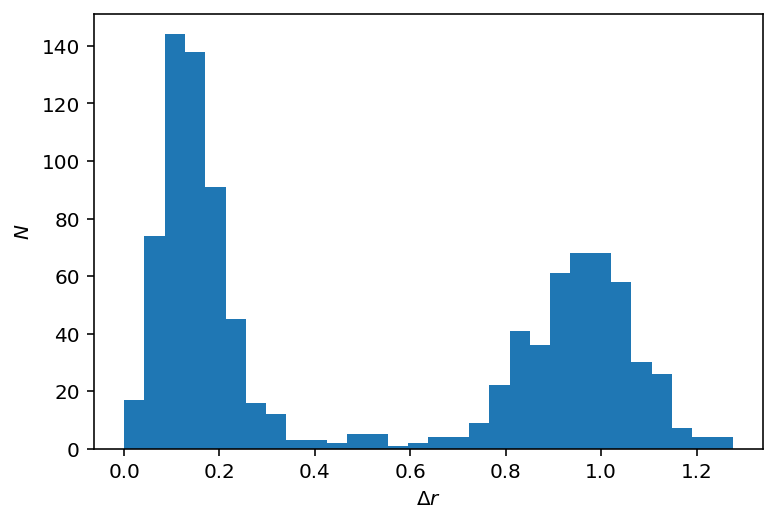

In [49]:
test_id = 200
start = traj[0].particles.position[test_id]
box = traj[0].configuration.box # this box is constant throughout the sim
out = []
for snap in traj:
    next_pos = snap.particles.position[test_id]
    wrapped_vec = cube_pbc_wrap(start, next_pos, box)
    norm = la.norm(wrapped_vec)
    out.append(norm)
plt.hist(out, bins=30)
plt.xlabel(r'$\Delta r$')
plt.ylabel(r'$N$')

Text(0.5, 0, '$t$')

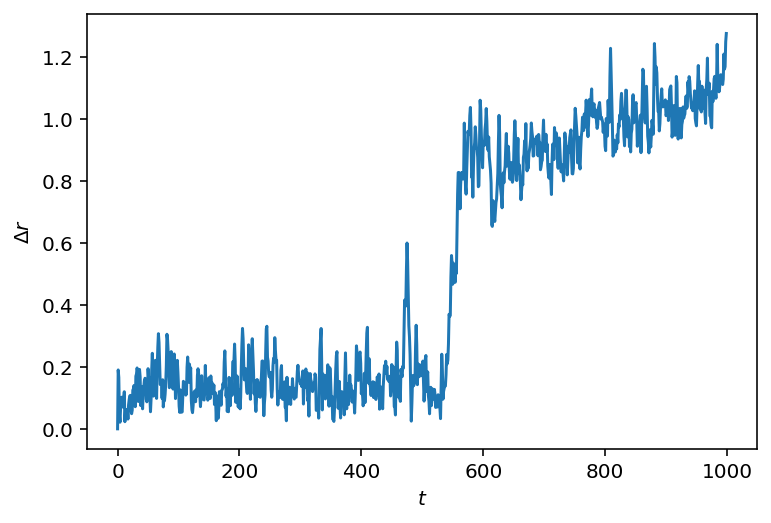

In [50]:
start = traj[0].particles.position[test_id]
box = traj[0].configuration.box # this box is constant throughout the sim
out = []
for snap in traj:
    next_pos = snap.particles.position[test_id]
    wrapped_vec = cube_pbc_wrap(start, next_pos, box)
    norm = la.norm(wrapped_vec)
    out.append(norm)
plt.plot(out)
plt.ylabel(r'$\Delta r$')
plt.xlabel(r'$t$')

0.2251595369517329 473


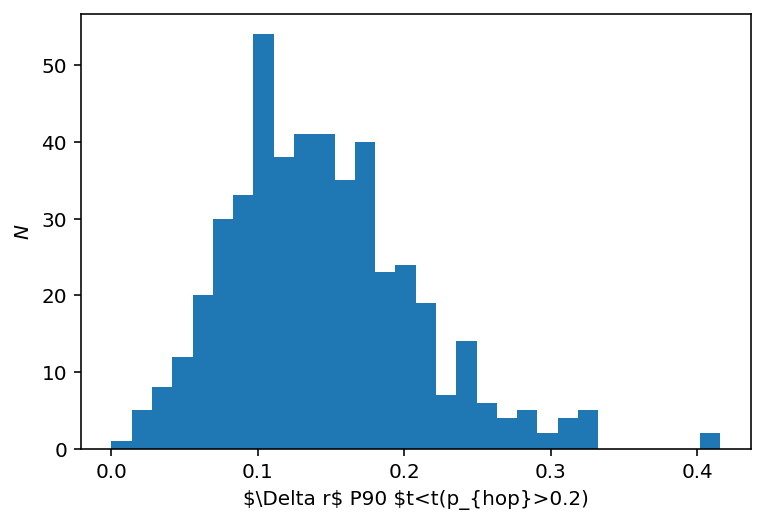

In [91]:
test_id = 200
start = traj[0].particles.position[test_id]
box = traj[0].configuration.box # this box is constant throughout the sim

idx = np.min(np.where(phop[:,test_id] > 0.2))

out = []
for snap in traj[:idx]:
    next_pos = snap.particles.position[test_id]
    wrapped_vec = cube_pbc_wrap(start, next_pos, box)
    norm = la.norm(wrapped_vec)
    out.append(norm)
plt.hist(out, bins=30)
plt.xlabel(r'$\Delta r$')
plt.ylabel(r'$N$')
print(np.percentile(out, 90), idx)

In [81]:
phop

array([[0.02274294, 0.02194287, 0.13478721, ..., 0.02144928, 0.01550898,
        0.02120112],
       [0.0219351 , 0.02226688, 0.13628511, ..., 0.02173093, 0.01553678,
        0.02133017],
       [0.02079006, 0.02226842, 0.13338269, ..., 0.02216405, 0.01595689,
        0.02179373],
       ...,
       [0.02100784, 0.06312943, 0.01526172, ..., 0.01853556, 0.01313524,
        0.02446879],
       [0.02097057, 0.06681521, 0.01497515, ..., 0.01893814, 0.01235362,
        0.02390772],
       [0.02072169, 0.07023397, 0.0148996 , ..., 0.01946607, 0.01174364,
        0.02246794]])

Text(0.5, 0, '$\\Delta r$ P90 $t<t(p_{hop}>0.2)$')

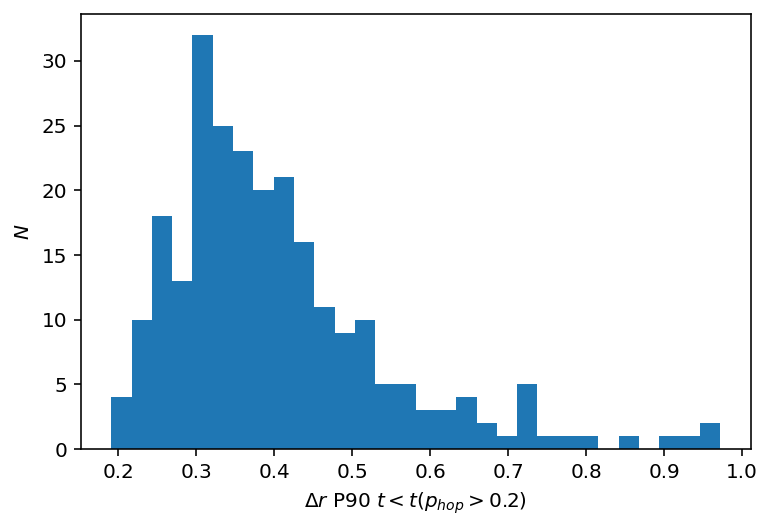

In [90]:
perc = []
box = traj[0].configuration.box # this box is constant throughout the sim

max_idx = len(traj)
for test_id in range(256):
    start = traj[0].particles.position[test_id]
    out = []
    cond = np.where(phop[:,test_id] > 0.2)
    idx = np.min(cond) if len(cond[0]) > 0 else max_idx
    if idx > 0:
        for snap in traj[:idx]:
            next_pos = snap.particles.position[test_id]
            wrapped_vec = cube_pbc_wrap(start, next_pos, box)
            norm = la.norm(wrapped_vec)
            out.append(norm)
        dat = np.percentile(out, 90)
        perc.append(dat)
plt.hist(perc, bins=30)
plt.ylabel(r"$N$")
plt.xlabel(r"$\Delta r$ P90 $t<t(p_{hop}>0.2)$")

Text(0.5, 0, '$\\Delta r$ P90 $t<t(p_{hop}>0.1)$')

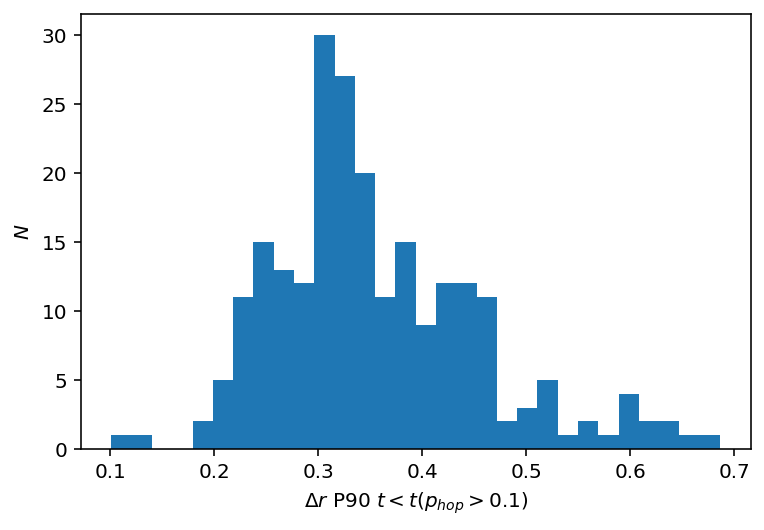

In [92]:
perc = []
box = traj[0].configuration.box # this box is constant throughout the sim

max_idx = len(traj)
for test_id in range(256):
    start = traj[0].particles.position[test_id]
    out = []
    cond = np.where(phop[:,test_id] > 0.1)
    idx = np.min(cond) if len(cond[0]) > 0 else max_idx
    if idx > 0:
        for snap in traj[:idx]:
            next_pos = snap.particles.position[test_id]
            wrapped_vec = cube_pbc_wrap(start, next_pos, box)
            norm = la.norm(wrapped_vec)
            out.append(norm)
        dat = np.percentile(out, 90)
        perc.append(dat)
plt.hist(perc, bins=30)
plt.ylabel(r"$N$")
plt.xlabel(r"$\Delta r$ P90 $t<t(p_{hop}>0.1)$")